In [1]:
# Imports
from typing import List, Optional, Tuple, Union

import torch
import torch.nn as nn
from torchvision.transforms import Resize, ToPILImage, GaussianBlur, CenterCrop
from torchvision.io import read_image
from datasets import load_dataset
from diffusers.pipelines import ScoreSdeVePipeline
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import ImagePipelineOutput
from matplotlib import pyplot as plt
from IPython.display import display

/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'     # Update this line if you want to use a different device such as TPU or Macbook's MPS
PRETRAINED = "google/ncsnpp-celebahq-256"
# PRETRAINED = "google/ncsnpp-church-256"
TEST_IMAGE = "test_celabhq.png"
# TEST_IMAGE = "test_lsun_church.png"
TIME_BETWEEN_DEBUG = 200

In [ ]:
# Dataset (save test images)

DATASET = 'tglcourse/lsun_church_train'
dataset = load_dataset(DATASET)
dataset['train'][0]['image'].save('test_lsun_church.png')

In [6]:
# Load data
unconditional_pipeline = ScoreSdeVePipeline.from_pretrained(PRETRAINED).to(device=DEVICE)
resize = Resize(256)
crop = CenterCrop(256)
test_img = read_image(TEST_IMAGE)
test_img = crop(resize(test_img) / 256)

diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 17.42it/s]
/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [39]:
# Utilities

def show_img(img, size = 3) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(img.squeeze().permute(-2,-1,-3))
    plt.axis('off')
    plt.show()
tensor_to_PIL = ToPILImage()

def tweedie(x_t, score, sigma):
  return x_t + score * sigma**2


class GradientAdditionPipeline(ScoreSdeVePipeline):

    def add_conditional_gradient(self, sample, output, y, sigma):
        raise NotImplementedError

    @torch.no_grad()
    def __call__(
        self,
        y,
        batch_size: int = 1,
        num_inference_steps: int = 2000,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        debug: bool = False,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        img_size = self.unet.config.sample_size
        shape = (batch_size, 3, img_size, img_size)

        model = self.unet

        sample = randn_tensor(shape, generator=generator) * self.scheduler.init_noise_sigma
        sample = sample.to(self.device)

        self.scheduler.set_timesteps(num_inference_steps)
        self.scheduler.set_sigmas(num_inference_steps)

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            sigma_t = self.scheduler.sigmas[i] * torch.ones(shape[0], device=self.device)

            # correction step
            for _ in range(self.scheduler.config.correct_steps):
                model_output = self.unet(sample, sigma_t).sample
                model_output = self.add_conditional_gradient(sample, model_output, y, sigma_t)
                sample = self.scheduler.step_correct(model_output, sample, generator=generator).prev_sample

            # prediction step
            model_output = model(sample, sigma_t).sample
            model_output =  self.add_conditional_gradient(sample, model_output, y, sigma_t)
            output = self.scheduler.step_pred(model_output, t, sample, generator=generator)

            sample, sample_mean = output.prev_sample, output.prev_sample_mean

            if i % TIME_BETWEEN_DEBUG == 0 and debug:
                show_img(sample[0].cpu())

        sample = sample_mean.clamp(0, 1)
        sample = sample.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            sample = self.numpy_to_pil(sample)

        if not return_dict:
            return (sample,)

        return ImagePipelineOutput(images=sample)

class ConstraintProjectionPipeline(ScoreSdeVePipeline):

    def project(self, sample, y, sigma):
        raise NotImplementedError

    @torch.no_grad()
    def __call__(
        self,
        y,
        batch_size: int = 1,
        num_inference_steps: int = 2000,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        debug: bool = False,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        img_size = self.unet.config.sample_size
        shape = (batch_size, 3, img_size, img_size)

        model = self.unet

        sample = randn_tensor(shape, generator=generator) * self.scheduler.init_noise_sigma
        sample = sample.to(self.device)

        self.scheduler.set_timesteps(num_inference_steps)
        self.scheduler.set_sigmas(num_inference_steps)

        upscaled_y = torch.repeat_interleave(y[0], y[1], dim=-2)
        upscaled_y = torch.repeat_interleave(upscaled_y, y[1], dim=-1)

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            sigma_t = self.scheduler.sigmas[i] * torch.ones(shape[0], device=self.device)

            # correction step
            for _ in range(self.scheduler.config.correct_steps):
                model_output = self.unet(sample, sigma_t).sample
                sample = self.scheduler.step_correct(model_output, sample, generator=generator).prev_sample
                sample = self.project(sample, y, self.scheduler.sigmas[i])

            # prediction step
            model_output = model(sample, sigma_t).sample
            output = self.scheduler.step_pred(model_output, t, sample, generator=generator)

            sample, sample_mean = output.prev_sample, output.prev_sample_mean

            sample = self.project(sample, y, self.scheduler.sigmas[i])

            if i % 200 == 0 and debug:
                show_img(sample[0].cpu())

        sample = sample_mean.clamp(0, 1)
        sample = sample.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            sample = self.numpy_to_pil(sample)

        if not return_dict:
            return (sample,)

        return ImagePipelineOutput(images=sample)

# Super Resolution

In [44]:
class SuperResolutionPipeline(GradientAdditionPipeline):
    def add_conditional_gradient(self, sample, output, y, sigma):
        y, kernel_size = y
        pool = nn.AvgPool2d(kernel_size=kernel_size, stride=kernel_size)
        with torch.enable_grad():
            sample.requires_grad = True
            d_sample = pool(sample)
            diff = d_sample - y
            sigma = sigma[0] # sigma is the same across batches
            sigma = sigma / kernel_size # STD, Not Variance!!
            sigma = sigma
            dist = torch.distributions.Normal(0,sigma)
            l_p_x_y = dist.log_prob(diff)
            l_p_x_y.sum().backward()
            output += sample.grad
        return output

In [45]:
class SuperResolutionProjectionPipeline(ConstraintProjectionPipeline):
    def upscale(self, img, kernel_size):
        upscaled = torch.repeat_interleave(img, kernel_size, dim=-2)
        upscaled = torch.repeat_interleave(upscaled, kernel_size, dim=-1)
        return upscaled

    def project(self, sample, y, sigma):
        y, kernel_size = y
        pool = nn.AvgPool2d(kernel_size=kernel_size, stride=kernel_size)
        diff = sample - self.upscale(pool(sample), kernel_size)
        return self.upscale(y, kernel_size) + diff

In [82]:
class PseudoguidedSuperResolutionPipeline(GradientAdditionPipeline):
    def add_conditional_gradient(self, sample, output, y, sigma):
        y, kernel_size = y
        pool = nn.AvgPool2d(kernel_size=kernel_size, stride=kernel_size)

        # H = AB
        # H H^T 
        # = AB(AB)T
        # = ABB^TA^T
        # Where A is some matrix conducting row reorderings
        # And B the pooling matrix
        # B @ B^T = pooling_factor * I
        # A is orthogonal... and A I A^T is just the identity matrix
        # So we can bring the scalar out in front
        # And the end result is just the scalar identity matrix
        # 

        with torch.enable_grad():
            sample.requires_grad = True 
            x_hat = tweedie(sample, output, sigma)
            d_sample = pool(x_hat)
            r = sigma
            sigma_0 = r / kernel_size
            dist = torch.distributions.Normal(d_sample, sigma_0)
            l_p_x_y = torch.nan_to_num(dist.log_prob(y))
            l_p_x_y.sum().backward()
            output += sample.grad
        return output

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:35<00:00, 10.51it/s]


'Original'

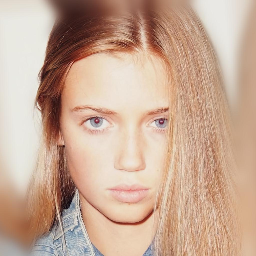

'Generated'

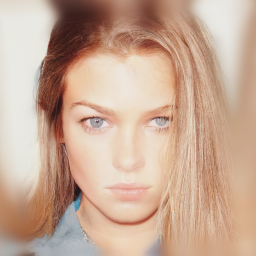

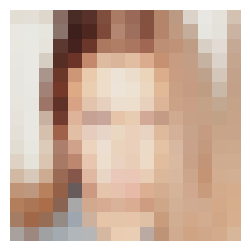

In [83]:
# Execution
KERNEL_SIZE = 16

pool = nn.AvgPool2d(kernel_size=KERNEL_SIZE, stride=KERNEL_SIZE)
downsampled_img = pool(test_img).to(device=DEVICE)
plt.axis('off')
plt.gcf().set_size_inches(3,3)
plt.imshow(downsampled_img.cpu().permute(-2,-1,-3))

# pipeline = SuperResolutionPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
# img_a = pipeline((downsampled_img, KERNEL_SIZE), batch_size=1, target=False, num_inference_steps=1000, debug=False).images[0]
# pipeline = SuperResolutionProjectionPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
# img_b = pipeline((downsampled_img, KERNEL_SIZE), batch_size=1, target=False, num_inference_steps=1000, debug=False).images[0]
pipeline = PseudoguidedSuperResolutionPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
img_c = pipeline((downsampled_img, KERNEL_SIZE), batch_size=1, target=False, num_inference_steps=1000, debug=False).images[0]
display("Original", tensor_to_PIL(test_img), "Generated", img_c)

# Manifold Constrained Inpainting

In [ ]:


class MCGInpainterPipeline(ScoreSdeVePipeline):

    @torch.no_grad()
    def __call__(
        self,
        data: torch.Tensor,
        mask: torch.Tensor,
        batch_size: int = 1,
        num_inference_steps: int = 2000,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        alpha = 1,
        mcg = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:

        img_size = self.unet.config.sample_size
        shape = (batch_size, 3, img_size, img_size)

        model = self.unet

        sample = randn_tensor(shape, generator=generator) * self.scheduler.init_noise_sigma
        sample = sample.to(self.device)
        # don't need to overwrite initial sample,
        # since it should be very noised at the start anyways, due to annealed langevin dynamics
        # sample = data * mask + sample * (1. - mask)
        # show_img(tensor_to_image(sample))
        data = data * mask

        self.scheduler.set_timesteps(num_inference_steps)
        self.scheduler.set_sigmas(num_inference_steps)

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            sigma_t = self.scheduler.sigmas[i] * torch.ones(shape[0], device=self.device)
            std = self.scheduler.sigmas[i]

            x_i = sample
            # correction step
            for _ in range(self.scheduler.config.correct_steps):
                model_output = self.unet(sample, sigma_t).sample
                sample = self.scheduler.step_correct(model_output, sample, generator=generator).prev_sample

                 # Constaint Step
                masked_data = data + torch.randn_like(sample) * std
                sample = sample * (1. - mask) + masked_data * mask

            # prediction step
            
            model_output = model(sample, sigma_t).sample

            output = self.scheduler.step_pred(model_output, t, sample, generator=generator)
            sample, sample_mean = output.prev_sample, output.prev_sample_mean

            # MCG Step
            if mcg:
                score = model(x_i, sigma_t).sample
                with torch.enable_grad():
                    x_i.requires_grad = True
                    x_hat = tweedie(x_i, score, std)
                    y_hat = mask * x_hat
                    dist = (y_hat-data).pow(2)
                    dist_norm = torch.sqrt(dist.sum([-1,-2,-3]))
                    a = alpha / dist_norm
                    dist.sum().backward()
                    a = a.reshape((*a.shape, 1, 1, 1))
                    sample = sample - a * x_i.grad 

            # Constaint Step
            masked_data = data + torch.randn_like(sample) * std
            sample = sample * (1. - mask) + masked_data * mask
            sample_mean = sample_mean * (1 - mask) + data * mask


        sample = sample_mean.clamp(0, 1)
        sample = sample.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            sample = self.numpy_to_pil(sample)

        if not return_dict:
            return (sample,)

        return ImagePipelineOutput(images=sample)


In [ ]:
mask = torch.ones_like(test_img) 
size = 80
mask[:,128-size:128+size, 128-size: 128+size] = 0
masked_img = test_img * mask

mask = mask.to(device=DEVICE)
masked_img = masked_img.to(device=DEVICE)

pipeline = MCGInpainterPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
images = pipeline(masked_img, mask=mask, batch_size=3, target=False, num_inference_steps=1000, mcg=True).images

display(*images)

# Colorisation

In [ ]:
def grayscale(image_tensor: torch.Tensor) -> torch.Tensor:
    return torch.mean(image_tensor, dim=1, keepdims=True).repeat(1, 3, 1, 1)

class ColorisationPipeline(GradientAdditionPipeline):
    """ Colorisation
    """
    def add_conditional_gradient(self, sample, output, y, sigma):
        with torch.enable_grad():
            sample.requires_grad = True
            gray_sample = grayscale(sample)
            diff = gray_sample[:, 0] - y[0][0].expand(3, 256, 256)
            sigma = sigma[0] # sigma is the same across batches
            sigma = sigma / 3.0**0.5 # STD, Not Variance!!
            dist = torch.distributions.Normal(0,sigma)
            l_p_x_y = dist.log_prob(diff)
            l_p_x_y.sum().backward()
            output += sample.grad
        return output

In [ ]:
gray = grayscale(test_img.unsqueeze(0)).to(device=DEVICE)
pipeline = ColorisationPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
images = pipeline(gray, batch_size=3, target=False, num_inference_steps=1000).images
display("Original", tensor_to_PIL(test_img), "Generated", *images, tensor_to_PIL(gray.squeeze()))

# Blur

In [ ]:
BLUR_KERNEL_SIZE = 27
gaussian_blur = GaussianBlur(BLUR_KERNEL_SIZE, sigma=2)

class DeblurringPipeline(GradientAdditionPipeline):
    """ Deblurring
    """
    def add_conditional_gradient(self, sample, output, y, sigma):
        with torch.enable_grad():
            sample.requires_grad = True
            blurred_sample = gaussian_blur(sample)
            diff = y - blurred_sample
            sigma = sigma[0]
            dist = torch.distributions.Normal(0,sigma)
            l_p_x_y = dist.log_prob(diff)
            l_p_x_y.sum().backward()
            output += sample.grad
        return output

In [ ]:
blurred = gaussian_blur(test_img).to(device=DEVICE)
pipeline = DeblurringPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
images = pipeline(blurred, batch_size=1, target=False, num_inference_steps=1000).images
display("Original", tensor_to_PIL(test_img), "Generated", *images, tensor_to_PIL(blurred))

# Imputation (PseudoInverse Guided)